In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import matplotlib.ticker as ticker
from read_struct import read_struct

# Structure factor (input HTT q)

In [2]:
def calc_sf(q, paramlist, mlist):
    # q vector
    q = np.asarray([2*q[2], 4*q[0], 2*q[1] ])
    # Make a list of modes
    modelist = [ item[0][0]+item[0][1] for item in mlist ]
    amps = { mode: par for mode,par in zip(modelist, paramlist) }
    
    # Loop through the mode list and compute atomic positions
    la_r = np.zeros([64, 3])
    cu_r = np.zeros([32, 3])
    
    for item in mlist:
        mode = item[0][0]
        atom = item[0][1]
        amplitude = amps[mode+atom]
        
        if atom[:1]=='L':
            if np.amax(la_r)==0:
                la_r += item[1][:, 0:3]
            la_r += amplitude*item[1][:,3:]

        if atom[:1]=='C':
            if np.amax(cu_r)==0:
                cu_r += item[1][:, 0:3]
            cu_r += amplitude*item[1][:,3:] 
              
    # Get the form factor 
    def ff_lba(q):
        q1 = ( (q[1]/7.55/2)**2+(q[2]/7.55)**2+(q[0]/13.2/2)**2 )**0.5
        ff_ba = 19.75*np.exp(-3.431*q1**2)+17.514*np.exp(-0.362*q1**2)+10.885*np.exp(-21.358*q1**2)+0.3216*np.exp(-70.309*q1**2)+65.15*np.exp(-0.001418*q1**2)-59.618171
        ff_la = 19.689*np.exp(-3.146*q1**2)+17.346*np.exp(-0.3396*q1**2)+11.356*np.exp(-18.754*q1**2)+0.0994*np.exp(-90.3455*q1**2)+82.358*np.exp(-0.001072*q1**2)-76.847
        ff_lba = ff_la*1.875 + ff_ba*0.125
        return ff_lba
    def ff_cu(q):
        q1 = ( (q[1]/7.55/2)**2+(q[2]/7.55)**2+(q[0]/13.2/2)**2 )**0.5
        ff_cu = 11.896*np.exp(-3.379*q1**2)+16.345*np.exp(-0.001*q1**2)+5.8*np.exp(-8.134*q1**2)+1.049*np.exp(-20.527*q1**2)+6.789*np.exp(-0.2547*q1**2)-14.8784
        return ff_cu
    def ff_o(q):
        q1 = ( (q[1]/7.55/2)**2+(q[2]/7.55)**2+(q[0]/13.2/2)**2 )**0.5
        ff_o = 3.107*np.exp(-19.868*q1**2)+3.235*np.exp(-6.96*q1**2)+1.149*np.exp(-0.17*q1**2)+0.784*np.exp(-65.694*q1**2)+0.677*np.exp(-0.631*q1**2)+0.046
        return ff_o
    
    # Multiply by exponential term to get the structure factor
    sfactor = ff_lba(q)*np.exp(1j*2*np.pi*la_r.dot(q)).sum() 
    sfactor += ff_cu(q)*np.exp(1j*2*np.pi*cu_r.dot(q)).sum() 
 
    # Use scaling factor of 477, based on Bragg peak intensities
    return  np.abs(sfactor)**2

# Parameter values from fit

In [3]:
# Best values
par0 = [7.16E-05, 0, 0, 0, 0.000144628, 0.000277993, 0.00012075, 0.000918694, 0, 0, 0.000293537]
# Single layer only
par_single = [0,0,0,0,0, 0.000289215, 0.000114166,   0,0,0,0.000309188]
      
mlist = read_struct('s1_p1_structure.txt')
qlist = np.genfromtxt('peaklist.txt', skip_header=1)


# Plot the figure

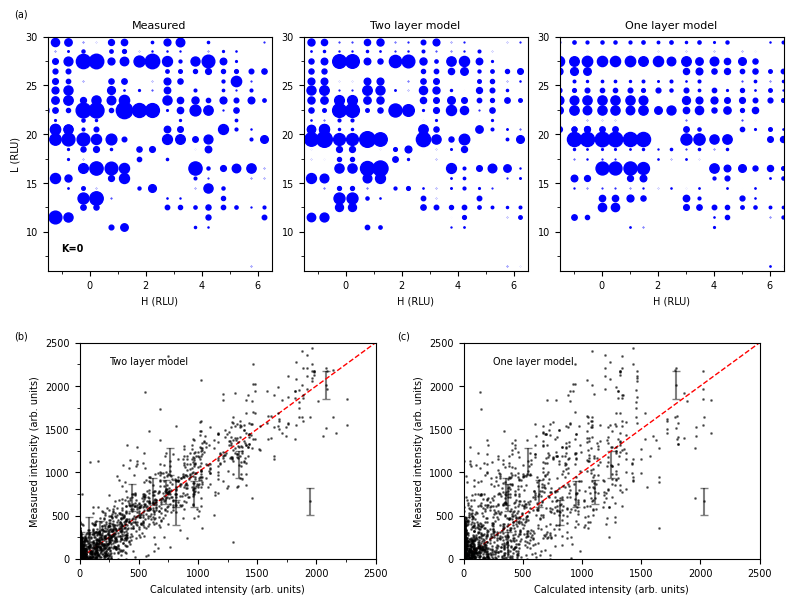

In [4]:
# Make the figure and axes

font = {'size' : 7}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(8,6))

ax1a = fig.add_axes([0.06, 0.55, 0.28, 0.39])
ax1b = fig.add_axes([0.38, 0.55, 0.28, 0.39])
ax1c = fig.add_axes([0.70, 0.55, 0.28, 0.39])


axa = fig.add_axes([0.1, 0.07, 0.37, 0.36])
axb = fig.add_axes([0.58, 0.07, 0.37, 0.36])

ax1a.set_ylabel('L (RLU)')
ax1a.set_xlabel('H (RLU)')
ax1b.set_xlabel('H (RLU)')
ax1c.set_xlabel('H (RLU)')

ax1a.set_title('Measured',fontsize=8)
ax1b.set_title('Two layer model',fontsize=8)
ax1c.set_title('One layer model',fontsize=8)
axa.set_xlabel('Calculated intensity (arb. units)')
axa.set_ylabel('Measured intensity (arb. units)')
axa.text(250, 2250, 'Two layer model', fontsize=7)
axb.text(250, 2250, 'One layer model', fontsize=7)
ax1a.text(-1,8,'K=0',fontsize=7, weight='bold' )

axb.set_xlabel('Calculated intensity (arb. units)')
axb.set_ylabel('Measured intensity (arb. units)')

ax1a.text(-2.7,32,'(a)',fontsize=7)
ax1a.text(-2.7,-1,'(b)',fontsize=7)
ax1a.text(11,-1,'(c)',fontsize=7)

# Plot the measured and calculated values
ms = 4
norm = 200
datarr1 = []
datarr2 = []

for line in qlist:
    h = line[0]
    k = line[1]
    l = line[2]
    q = np.asarray([h, k, l])
    inti = line[4]
    err = line[5]
    
    inti_2lay = calc_sf(q, par0, mlist)
    inti_1lay = calc_sf(q, par_single, mlist)
    datarr1.append(np.asarray([ inti_2lay,inti, err ]))
    datarr2.append(np.asarray([ inti_1lay,inti, err ]))
    
    if k==0:
        ax1a.plot(h, l, marker='o', ms=inti/norm, ls='None', color='b')       
        ax1b.plot(h,l,ms=inti_2lay/norm, marker='o', color='b')      
        ax1c.plot(h+0.24,l,ms=inti_1lay/norm, marker='o', color='b')

datarr1 = np.asarray(datarr1)
datarr2 = np.asarray(datarr2)
axa.errorbar(datarr1[:,0],datarr1[:,1], datarr1[:,2],errorevery=100, color='k', capsize=3, linestyle=None, fmt='.', markersize=2, alpha=.5)  
axb.errorbar(datarr2[:,0],datarr2[:,1], datarr2[:,2],errorevery=100, color='k', capsize=3, linestyle=None, fmt='.', markersize=2, alpha=.5)  

ax1a.set_xlim(-1.5,6.5)
ax1a.set_ylim(6,30)  
ax1b.set_xlim(-1.5,6.5)
ax1b.set_ylim(6,30)  
ax1c.set_xlim(-1.5,6.5)
ax1c.set_ylim(6,30) 

axa.set_xlim(0,2500)
axa.set_ylim(0,2500)
axa.plot(np.linspace(-1000,3000,10), np.linspace(-1000,3000,10), ls='--',color='r', linewidth=1)

axb.set_xlim(0,2500)
axb.set_ylim(0,2500)
axb.plot(np.linspace(-1000,3000,10), np.linspace(-1000,3000,10), ls='--',color='r', linewidth=1)

ax1a.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax1a.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1a.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax1a.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1b.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax1b.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1b.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax1b.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1c.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax1c.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1c.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax1c.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))


axa.xaxis.set_major_locator(ticker.MultipleLocator(500))
axa.xaxis.set_minor_locator(ticker.MultipleLocator(250))
axa.yaxis.set_major_locator(ticker.MultipleLocator(500))
axa.yaxis.set_minor_locator(ticker.MultipleLocator(250))
